In [1]:
import numpy
import numpy as np
import time
import datetime
import netCDF4
import matplotlib.pylab as plt
import os,sys,glob
from multiprocessing import Pool
#import odb
from eccodes import *
from functools import partial
from collections import OrderedDict
import subprocess
import json
import gzip
import copy
import pickle
import xarray as xr
import pickle
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
matplotlib.rcParams.update({'font.size': 20})

plt.rcParams['lines.linewidth'] = 3

import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.getcwd()+'/../../cds-backend/code/')
import cds_eua4 as eua
sys.path.append(os.getcwd()+'/..')
import trajectory as trj

import h5py
import ray
import pyproj
# ray.init(num_cpus=7)


no config found


In [2]:

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def datetime_to_seconds(dates, ref='1900-01-01T00:00:00'):
    """ from datetime64 to seconds since 1900-01-01 00:00:00"""
    return ((dates - np.datetime64(ref)) / np.timedelta64(1, 's')).astype(np.int64)

def seconds_to_datetime(seconds, ref='1900-01-01'):
    """ from seconds to datetime64 """
    seconds = np.asarray(seconds)
    return pd.to_datetime(seconds, unit='s', origin=ref)

# Projection Types

# Comparison calc - original

In [4]:
def par_read_bufr_stn_nofeedback_mre_interp(varno,bufrfile):
    pltcount = 0
    alldata=''
    alldict=dict()

    bufrlist=[]
    tx=time.time()
#     try:
    f = open(bufrfile)
    print(f)
    cnt = 0
    output = {}
    # loop over the messages in the file
    bc = 0
    

    plev_vals = {}    
    rmse_sum_lon_s={}
    rmse_sum_lat_s={}
    rmse_sum_lon_sr={}
    rmse_sum_lat_sr={}
    rmse_sum_lon_sri={}
    rmse_sum_lat_sri={}

    stdplevs = [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]

    for i in stdplevs:
        plev_vals[i] = []
        rmse_sum_lon_s[i] = []
        rmse_sum_lat_s[i] = []
        rmse_sum_lon_sr[i] = []
        rmse_sum_lat_sr[i] = []
        rmse_sum_lon_sri[i] = []
        rmse_sum_lat_sri[i] = []

        
    while 1:
#         try:
        # get handle for message
        bufr = codes_bufr_new_from_file(f)
        if bufr is None:
            break
        # we need to instruct ecCodes to expand all the descriptors
        # i.e. unpack the data section
#         print (codes_get_array(bufr,'dataSubCategory'))
        if codes_get_array(bufr,'dataSubCategory')[0]!=109:
#             print('not 109')
            codes_release(bufr)
            continue
        codes_set(bufr, 'unpack', 1)
        # get all the timePeriods
        iterid = codes_bufr_keys_iterator_new(bufr)
#         print('iterid ', iterid)

        # loop over the keys
        #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
#         print (codes_get_array(bufr,'dataSubCategory')[0])
            #codes_release(bufr)
            #continue
        hires=False
        while codes_bufr_keys_iterator_next(iterid):

#             print key name
            keyname = codes_bufr_keys_iterator_get_name(iterid)
#                 print(keyname,codes_get_array(bufr,keyname))
            #if keyname in ['#1#blockNumber','#1#stationNumber']:
                #print (keyname,codes_get_array(bufr,keyname))
            if 'latitudeDisplacement' in keyname:
                hires=True
        if not hires:
            codes_bufr_keys_iterator_delete(iterid)
            codes_release(bufr)
            continue
        ## delete the key iterator
        codes_bufr_keys_iterator_delete(iterid)
        output['datum'] = float(codes_get_array(bufr, "typicalDate")[0])
#             if str(output['datum'])[4:6] != '12':
#                 codes_release(bufr)
#                 continue
        output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
        output['pressure'] = codes_get_array(bufr, "pressure")
        output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
        output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
        output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
        output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
        output['airTemperature'] = codes_get_array(bufr, "airTemperature")
        dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
        output['windDirection'] = codes_get_array(bufr, "windDirection")
        output['windSpeed'] = codes_get_array(bufr, "windSpeed")
        output['lat'] = codes_get(bufr, "latitude")
        output['lon'] = codes_get(bufr, "longitude")
        output['alt'] = float(codes_get(bufr, "heightOfStation"))
        output['blockNumber'] = codes_get(bufr, "blockNumber")
        output['stationNumber'] = codes_get(bufr, "stationNumber")
        try:
            out = pd.DataFrame.from_dict(output)
            cont = True
        except:
            cont = False
            
        if cont:
            # try:
            out = out[out.airTemperature < 350]
            out = out[out.airTemperature > 180]

            out['u'] = out.windSpeed * np.cos(np.radians(270.0 - out.windDirection))
            out['v'] = out.windSpeed * np.sin(np.radians(270.0 - out.windDirection))

            reduced_out = out[np.isin(out.pressure, stdplevs)]
            if len(reduced_out) < 5:
                continue
                
            if (np.abs(np.nanmean(out.longitudeDisplacement)) < 0.001) or (np.abs(np.nanmean(out.latitudeDisplacement)) < 0.001) or (np.max(np.abs(out.latitudeDisplacement)) > 10):
                continue
            
            if (len(out) < 0) or (len(reduced_out) < 3):
                continue
                
            num_p = 20
            p_list = np.linspace(out.pressure.iloc[0], out.pressure.iloc[-1], num=num_p)
            true_p_list = list(reduced_out.pressure)
            for i in p_list:
                true_p_list.append(find_nearest(out.pressure, i))
            interpolated_reduced_out = out[np.isin(out.pressure, true_p_list)]
            # display(interpolated_reduced_out)
            # display(reduced_out)
            u_new = []
            v_new = []
            # print(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.u))
            # print((np.interp(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.u))))
            
            # u_new = (np.interp(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.u)))
            # v_new = (np.interp(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.v)))
            
            for k in range(len(interpolated_reduced_out)):
                if reduced_out.pressure.iloc[0] >= interpolated_reduced_out.pressure.iloc[k] >= reduced_out.pressure.iloc[-1]:
                    u_new.append(np.interp(interpolated_reduced_out.pressure.iloc[k], np.flip(reduced_out.pressure), np.flip(reduced_out.u)))
                    v_new.append(np.interp(interpolated_reduced_out.pressure.iloc[k], np.flip(reduced_out.pressure), np.flip(reduced_out.v)))
                else:
                    u_new.append(np.nan)
                    v_new.append(np.nan)

            u = np.array(u_new)
            v = np.array(v_new)
            interpolated_reduced_out['ip_u'] = u
            interpolated_reduced_out['ip_v'] = v
            interpolated_reduced_out = interpolated_reduced_out.dropna(subset=['ip_u', 'ip_v'])
                
            reduced_interp_sph_lat_disp, reduced_interp_sph_lon_disp, sph_rts = trj.trajectory(
                lat=out.lat.iloc[0], lon=out.lon.iloc[0],
                temperature=np.array(interpolated_reduced_out.airTemperature), u=np.array(interpolated_reduced_out.ip_u), v=np.array(interpolated_reduced_out.ip_v),
                pressure=np.array(interpolated_reduced_out.pressure),
                transport_type='sphere')
            
            # print(reduced_interp_sph_lat_disp, reduced_interp_sph_lon_disp)

            sph_lat_disp, sph_lon_disp, sph_rts = trj.trajectory(
                lat=out.lat.iloc[0], lon=out.lon.iloc[0],
                temperature=np.array(out.airTemperature), u=np.array(out.u), v=np.array(out.v),
                pressure=np.array(out.pressure),
                )

            reduced_sph_lat_disp, reduced_sph_lon_disp, reduced_sph_rts = trj.trajectory(
                lat=reduced_out.lat.iloc[0], lon=reduced_out.lon.iloc[0],
                temperature=np.array(reduced_out.airTemperature), u=np.array(reduced_out.u), v=np.array(reduced_out.v),
                pressure=np.array(reduced_out.pressure),
                )

            ell_lat_disp, ell_lon_disp, ell_rts = trj.trajectory(
                lat=out.lat.iloc[0], lon=out.lon.iloc[0],
                temperature=np.array(out.airTemperature), u=np.array(out.u), v=np.array(out.v),
                pressure=np.array(out.pressure),
                transport_type='geod')

            reduced_ell_lat_disp, reduced_ell_lon_disp, reduced_ell_rts = trj.trajectory(
                lat=reduced_out.lat.iloc[0], lon=reduced_out.lon.iloc[0],
                temperature=np.array(reduced_out.airTemperature), u=np.array(reduced_out.u), v=np.array(reduced_out.v),
                pressure=np.array(reduced_out.pressure),
                transport_type='geod')
            

            for i in stdplevs:
                try:
                    rmse_sum_lon_s[i].append(
                        float(np.abs(np.array(sph_lon_disp)[out.pressure == i] - 
                              out[out.pressure == i].longitudeDisplacement.values)
                        / (np.abs(out[out.pressure == i].longitudeDisplacement.values))
                    ))
                    rmse_sum_lat_s[i].append(
                        float(np.abs(np.array(sph_lat_disp)[out.pressure == i] - 
                              out[out.pressure == i].latitudeDisplacement.values) 
                        / (np.abs(out[out.pressure == i].latitudeDisplacement.values))
                    ))
                    rmse_sum_lon_sr[i].append(
                        float(np.abs(np.array(reduced_sph_lon_disp)[reduced_out.pressure == i] - 
                              reduced_out[reduced_out.pressure == i].longitudeDisplacement.values) 
                        / (np.abs(reduced_out[reduced_out.pressure == i].longitudeDisplacement.values))
                    ))
                    rmse_sum_lat_sr[i].append(
                        float(np.abs(np.array(reduced_sph_lat_disp)[reduced_out.pressure == i] - 
                              reduced_out[reduced_out.pressure == i].latitudeDisplacement.values) 
                        / (np.abs(reduced_out[reduced_out.pressure == i].latitudeDisplacement.values))
                    ))
                    rmse_sum_lon_sri[i].append(
                        float(np.abs(np.array(reduced_interp_sph_lon_disp)[interpolated_reduced_out.pressure == i] - 
                              interpolated_reduced_out[interpolated_reduced_out.pressure == i].longitudeDisplacement.values) 
                        / (np.abs(reduced_out[reduced_out.pressure == i].longitudeDisplacement.values))
                    ))
                    rmse_sum_lat_sri[i].append(
                        float(np.abs(np.array(reduced_interp_sph_lat_disp)[interpolated_reduced_out.pressure == i] - 
                              interpolated_reduced_out[interpolated_reduced_out.pressure == i].latitudeDisplacement.values) 
                        / (np.abs(reduced_out[reduced_out.pressure == i].latitudeDisplacement.values))
                    ))
                    plev_vals[i].append(1)
                except:
                    rmse_sum_lon_s[i].append(np.nan)
                    rmse_sum_lat_s[i].append(np.nan)
                    rmse_sum_lon_sr[i].append(np.nan)
                    rmse_sum_lat_sr[i].append(np.nan)
                    rmse_sum_lon_sri[i].append(np.nan)
                    rmse_sum_lat_sri[i].append(np.nan)
                    plev_vals[i].append(0)
                    
            if True: #(pltcount < 25) == 0:
                startlat = out.lat.iloc[0]
                startlon = out.lon.iloc[0]
                print('length of input data:',len(out))
                print('significant levels:',len(reduced_out))
                print('lat: ',out.lat.iloc[0], '   lon: ', out.lon.iloc[0])
                print('date: ', out.datum.iloc[0], '   time: ', out.timePeriod.iloc[0])
                # display(interpolated_reduced_out)
                fig, ax1 = maplt.subplots(figsize=(15, 9))
                ax1.set_yscale('log')

                sph_dist = []
                for i in range(len(out.latitudeDisplacement)):
                    dist_i = trj.haversine(startlat, startlon, startlat + np.array(sph_lat_disp)[i], startlon + np.array(sph_lon_disp)[i])
                    sph_dist.append(dist_i)
                ax1.plot(np.array(sph_dist), out.pressure,color = 'blue', alpha = 1, label='calc disp')
                # ax1.plot(np.array(sph_lon_disp),out.pressure,color = 'red', alpha = 1, label='calc lon disp')
                
                red_dist = []
                for i in range(len(reduced_out.pressure)):
                    dist_i = trj.haversine(startlat, startlon, startlat + np.array(reduced_sph_lat_disp)[i], startlon + np.array(reduced_sph_lon_disp)[i])
                    red_dist.append(dist_i)
                ax1.plot(np.array(red_dist), reduced_out.pressure,color = 'cyan', alpha = 1, label='std plevs calc disp')
                # ax1.plot(np.array(reduced_sph_lon_disp),reduced_out.pressure,color = 'brown', alpha = 1, label='std plevs calc lon disp')

                orig_dist = []
                for i in range(len(out.latitudeDisplacement)):
                    dist_i = trj.haversine(startlat, startlon, startlat + out.latitudeDisplacement.iloc[i], startlon + out.longitudeDisplacement.iloc[i])
                    orig_dist.append(dist_i)
                ax1.plot(orig_dist,out.pressure,color = 'blue',alpha = 0.3, linewidth= 6, label='original disp')
                # ax1.plot(out.longitudeDisplacement,out.pressure, color = 'red',alpha = 0.3, linewidth= 6, label='original lon disp')

                ax1.set_ylabel('pressure (Pa)')
                ax1.set_xlabel('displacement (km)')
                ax1.tick_params(axis='x')
                ax1.set_ylim(ax1.get_ylim()[::-1])
                ax1.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

                ax1_2 = ax1.twiny()
                ax1_2.set_yscale('log')
                ax1_2.plot(out.u,out.pressure, color = 'green', alpha = 0.15, label='u')
                ax1_2.plot(out.v,out.pressure, color = 'orange', alpha = 0.15, label='v')
                ax1_2.plot(reduced_out.u,reduced_out.pressure, color = 'blue', alpha = 0.15, label='u')
                ax1_2.plot(reduced_out.v,reduced_out.pressure, color = 'red', alpha = 0.15, label='v')

                fig.tight_layout()  # otherwise the right y-label is slightly clipped
                maplt.title('Comparison of Displacements')
                maplt.legend()
                maplt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
                maplt.grid()
                maplt.show()
                maplt.close()
            pltcount += 1
            
            # except: 
            #     pass
            # break
            if pltcount > 30:
                break
    
    # limit = [5,95]
    # for i in stdplevs:
        
    #     rmse_sum_lat_s[i] = np.array(rmse_sum_lat_s[i])
    #     rmse_sum_lon_s[i] = np.array(rmse_sum_lon_s[i])
    #     rmse_sum_lat_sr[i] = np.array(rmse_sum_lat_sr[i])
    #     rmse_sum_lon_sr[i] = np.array(rmse_sum_lon_sr[i])
    #     rmse_sum_lat_sri[i] = np.array(rmse_sum_lat_sri[i])
    #     rmse_sum_lon_sri[i] = np.array(rmse_sum_lon_sri[i])
        
    #     outlier_drop = np.nanpercentile(rmse_sum_lat_s[i], limit)
    #     rmse_sum_lat_s[i][rmse_sum_lat_s[i] < outlier_drop[0]] = np.nan
    #     rmse_sum_lat_s[i][rmse_sum_lat_s[i] > outlier_drop[1]] = np.nan
        
    #     outlier_drop = np.nanpercentile(rmse_sum_lon_s[i], limit)
    #     rmse_sum_lon_s[i][rmse_sum_lon_s[i] < outlier_drop[0]] = np.nan
    #     rmse_sum_lon_s[i][rmse_sum_lon_s[i] > outlier_drop[1]] = np.nan
        
    #     outlier_drop = np.nanpercentile(rmse_sum_lat_sr[i], limit)
    #     rmse_sum_lat_sr[i][rmse_sum_lat_sr[i] < outlier_drop[0]] = np.nan
    #     rmse_sum_lat_sr[i][rmse_sum_lat_sr[i] > outlier_drop[1]] = np.nan
        
    #     outlier_drop = np.nanpercentile(rmse_sum_lon_sr[i], limit)
    #     rmse_sum_lon_sr[i][rmse_sum_lon_sr[i] < outlier_drop[0]] = np.nan
    #     rmse_sum_lon_sr[i][rmse_sum_lon_sr[i] > outlier_drop[1]] = np.nan
        
    #     outlier_drop = np.nanpercentile(rmse_sum_lat_sri[i], limit)
    #     rmse_sum_lat_sri[i][rmse_sum_lat_sri[i] < outlier_drop[0]] = np.nan
    #     rmse_sum_lat_sri[i][rmse_sum_lat_sri[i] > outlier_drop[1]] = np.nan
        
    #     outlier_drop = np.nanpercentile(rmse_sum_lon_sri[i], limit)
    #     rmse_sum_lon_sri[i][rmse_sum_lon_sri[i] < outlier_drop[0]] = np.nan
    #     rmse_sum_lon_sri[i][rmse_sum_lon_sri[i] > outlier_drop[1]] = np.nan
    
    # rmse_lat_s = []
    # rmse_lon_s = []
    # rmse_lat_sr = []
    # rmse_lon_sr = []
    # rmse_lat_sri = []
    # rmse_lon_sri = []
    # for i in stdplevs:
    #     # rmse_lat_s.append(np.sqrt(np.nanmean((rmse_sum_lat_s[i])**2)))
    #     # rmse_lon_s.append(np.sqrt(np.nanmean((rmse_sum_lon_s[i])**2)))
    #     # rmse_lat_sr.append(np.sqrt(np.nanmean((rmse_sum_lat_sr[i])**2)))
    #     # rmse_lon_sr.append(np.sqrt(np.nanmean((rmse_sum_lon_sr[i])**2)))
    #     # rmse_lat_sri.append(np.sqrt(np.nanmean((rmse_sum_lat_sri[i])**2)))
    #     # rmse_lon_sri.append(np.sqrt(np.nanmean((rmse_sum_lon_sri[i])**2)))
        
    #     rmse_lat_s.append(np.nanmean(rmse_sum_lat_s[i]))
    #     rmse_lon_s.append(np.nanmean(rmse_sum_lon_s[i]))
    #     rmse_lat_sr.append(np.nanmean(rmse_sum_lat_sr[i]))
    #     rmse_lon_sr.append(np.nanmean(rmse_sum_lon_sr[i]))
    #     rmse_lat_sri.append(np.nanmean(rmse_sum_lat_sri[i]))
    #     rmse_lon_sri.append(np.nanmean(rmse_sum_lon_sri[i]))

    
    # fig, ax1 = maplt.subplots(1, 3, figsize = (15,10))
    # ax1[0].set_yscale('log')
    # ax1[1].set_yscale('log')
    # ax1[0].plot(np.array(rmse_lat_s), stdplevs, color = 'blue', alpha = 0.3, label = 'lat MRE spher disp')
    # ax1[0].plot(np.array(rmse_lat_sr), stdplevs, color = 'blue', label = 'lat MRE reduced spher disp')
    # ax1[0].plot(np.array(rmse_lat_sri), stdplevs, color = 'green', label = 'lat MRE interp reduced spher disp')
    # ax1[0].set_ylim(ax1[0].get_ylim()[::-1])
    # ax1[0].set_ylabel('pressure (Pa)')
    # ax1[0].set_xlabel('Mean relative error of displacement')
    # ax1[0].legend(loc='upper center')
    # ax1[0].grid()
    
    
    # ax1[1].plot(np.array(rmse_lon_s), stdplevs, color = 'red', alpha = 0.3, label = 'lon MRE spher disp')
    # ax1[1].plot(np.array(rmse_lon_sr), stdplevs, color = 'red', label = 'lon MRE reduced spher disp')
    # ax1[1].plot(np.array(rmse_lon_sri), stdplevs, color = 'orange', label = 'lon MRE interp reduced spher disp')
    # ax1[1].set_ylim(ax1[1].get_ylim()[::-1])
    # ax1[1].set_ylabel('pressure (Pa)')
    # ax1[1].set_xlabel('Mean relative error of displacement')
    # ax1[1].legend(loc='upper center')
    # ax1[1].grid()
    
    # value_nr = []
    # for i in plev_vals:
    #     value_nr.append(np.sum(plev_vals[i]))
    # ax1[2].barh(stdplevs, value_nr, np.array(stdplevs)*7, color='g', alpha = 0.4, align='center')
    # ax1[2].set_ylim(ax1[2].get_ylim()[::-1])
    # ax1[2].set_xlabel('Number of Values')
    # ax1[2].tick_params(labelleft=False)
    # ax1[2].grid()
    
    # maplt.title('LEVEL MRE for Displacement')
    # maplt.show()
    # maplt.close()
    
    return out

In [5]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202012')
sodblist.sort(key=os.path.getsize)
out = par_read_bufr_stn_nofeedback_mre_interp(111, sodblist[0]) #'./out.bufr')# sodblist[0])


<_io.TextIOWrapper name='/users/staff/leo/ectrans/era5.bufr.202012' mode='r' encoding='UTF-8'>


length of input data: 3644
significant levels: 14
lat:  -40.900000000000006    lon:  174.98000000000002
date:  20201130.0    time:  213100.0


In [ ]:
# def par_read_bufr_stn_nofeedback_mre_interp(varno,bufrfile):
#     pltcount = 0
#     alldata=''
#     alldict=dict()

#     bufrlist=[]
#     tx=time.time()
# #     try:
#     f = open(bufrfile)
#     print(f)
#     cnt = 0
#     output = {}
#     # loop over the messages in the file
#     bc = 0
    

#     plev_vals = {}    
#     rmse_sum_lon_s={}
#     rmse_sum_lat_s={}
#     rmse_sum_lon_sr={}
#     rmse_sum_lat_sr={}
#     rmse_sum_lon_sri={}
#     rmse_sum_lat_sri={}

#     stdplevs = [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]

#     for i in stdplevs:
#         plev_vals[i] = []
#         rmse_sum_lon_s[i] = []
#         rmse_sum_lat_s[i] = []
#         rmse_sum_lon_sr[i] = []
#         rmse_sum_lat_sr[i] = []
#         rmse_sum_lon_sri[i] = []
#         rmse_sum_lat_sri[i] = []

        
#     while 1:
# #         try:
#         # get handle for message
#         bufr = codes_bufr_new_from_file(f)
#         if bufr is None:
#             break
#         # we need to instruct ecCodes to expand all the descriptors
#         # i.e. unpack the data section
# #         print (codes_get_array(bufr,'dataSubCategory'))
#         if codes_get_array(bufr,'dataSubCategory')[0]!=109:
# #             print('not 109')
#             codes_release(bufr)
#             continue
#         codes_set(bufr, 'unpack', 1)
#         # get all the timePeriods
#         iterid = codes_bufr_keys_iterator_new(bufr)
# #         print('iterid ', iterid)

#         # loop over the keys
#         #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
# #         print (codes_get_array(bufr,'dataSubCategory')[0])
#             #codes_release(bufr)
#             #continue
#         hires=False
#         while codes_bufr_keys_iterator_next(iterid):

# #             print key name
#             keyname = codes_bufr_keys_iterator_get_name(iterid)
# #                 print(keyname,codes_get_array(bufr,keyname))
#             #if keyname in ['#1#blockNumber','#1#stationNumber']:
#                 #print (keyname,codes_get_array(bufr,keyname))
#             if 'latitudeDisplacement' in keyname:
#                 hires=True
#         if not hires:
#             codes_bufr_keys_iterator_delete(iterid)
#             codes_release(bufr)
#             continue
#         ## delete the key iterator
#         codes_bufr_keys_iterator_delete(iterid)
#         try:
#             output['datum'] = float(codes_get_array(bufr, "typicalDate")[0])
#     #             if str(output['datum'])[4:6] != '12':
#     #                 codes_release(bufr)
#     #                 continue
#             output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
#             output['pressure'] = codes_get_array(bufr, "pressure")
#             output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
#             output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
#             output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
#             output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
#             output['airTemperature'] = codes_get_array(bufr, "airTemperature")
#             dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
#             output['windDirection'] = codes_get_array(bufr, "windDirection")
#             output['windSpeed'] = codes_get_array(bufr, "windSpeed")
#             output['lat'] = codes_get(bufr, "latitude")
#             output['lon'] = codes_get(bufr, "longitude")
#             output['alt'] = float(codes_get(bufr, "heightOfStation"))
#             output['blockNumber'] = codes_get(bufr, "blockNumber")
#             output['stationNumber'] = codes_get(bufr, "stationNumber")

#             out = pd.DataFrame.from_dict(output)
#             cont = True
#         except:
#             cont = False
            
#         codes_release(bufr)
            
#         if cont:
#             # try:
#             out = out[out.airTemperature < 350]
#             out = out[out.airTemperature > 180]

#             out['u'] = out.windSpeed * np.cos(np.radians(270.0 - out.windDirection))
#             out['v'] = out.windSpeed * np.sin(np.radians(270.0 - out.windDirection))

#             reduced_out = out[np.isin(out.pressure, stdplevs)]
#             if len(reduced_out) < 5:
#                 continue
                
#             if (np.abs(np.nanmean(out.longitudeDisplacement)) < 0.001) or (np.abs(np.nanmean(out.latitudeDisplacement)) < 0.001) or (np.max(np.abs(out.latitudeDisplacement)) > 10):
#                 continue
            
#             if (len(out) < 0) or (len(reduced_out) < 3):
#                 continue
                
#             num_p = 20
#             p_list = np.linspace(out.pressure.iloc[0], out.pressure.iloc[-1], num=num_p)
#             true_p_list = list(reduced_out.pressure)
#             for i in p_list:
#                 true_p_list.append(find_nearest(out.pressure, i))
#             interpolated_reduced_out = out[np.isin(out.pressure, true_p_list)]
#             # display(interpolated_reduced_out)
#             # display(reduced_out)
#             u_new = []
#             v_new = []
#             # print(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.u))
#             # print((np.interp(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.u))))
            
#             # u_new = (np.interp(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.u)))
#             # v_new = (np.interp(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.v)))
            
#             for k in range(len(interpolated_reduced_out)):
#                 if reduced_out.pressure.iloc[0] >= interpolated_reduced_out.pressure.iloc[k] >= reduced_out.pressure.iloc[-1]:
#                     u_new.append(np.interp(interpolated_reduced_out.pressure.iloc[k], np.flip(reduced_out.pressure), np.flip(reduced_out.u)))
#                     v_new.append(np.interp(interpolated_reduced_out.pressure.iloc[k], np.flip(reduced_out.pressure), np.flip(reduced_out.v)))
#                 else:
#                     u_new.append(np.nan)
#                     v_new.append(np.nan)

#             u = np.array(u_new)
#             v = np.array(v_new)
#             interpolated_reduced_out['ip_u'] = u
#             interpolated_reduced_out['ip_v'] = v
#             interpolated_reduced_out = interpolated_reduced_out.dropna(subset=['ip_u', 'ip_v'])
                
#             reduced_interp_sph_lat_disp, reduced_interp_sph_lon_disp, sph_rts = trj.trajectory(
#                 lat=out.lat.iloc[0], lon=out.lon.iloc[0],
#                 temperature=np.array(interpolated_reduced_out.airTemperature), u=np.array(interpolated_reduced_out.ip_u), v=np.array(interpolated_reduced_out.ip_v),
#                 pressure=np.array(interpolated_reduced_out.pressure),
#                 transport_type='sphere')
            
#             # print(reduced_interp_sph_lat_disp, reduced_interp_sph_lon_disp)

#             sph_lat_disp, sph_lon_disp, sph_rts = trj.trajectory(
#                 lat=out.lat.iloc[0], lon=out.lon.iloc[0],
#                 temperature=np.array(out.airTemperature), u=np.array(out.u), v=np.array(out.v),
#                 pressure=np.array(out.pressure),
#                 )

# #             reduced_sph_lat_disp, reduced_sph_lon_disp, reduced_sph_rts = trj.trajectory(
# #                 lat=reduced_out.lat.iloc[0], lon=reduced_out.lon.iloc[0],
# #                 temperature=np.array(reduced_out.airTemperature), u=np.array(reduced_out.u), v=np.array(reduced_out.v),
# #                 pressure=np.array(reduced_out.pressure),
# #                 )

# #             ell_lat_disp, ell_lon_disp, ell_rts = trj.trajectory(
# #                 lat=out.lat.iloc[0], lon=out.lon.iloc[0],
# #                 temperature=np.array(out.airTemperature), u=np.array(out.u), v=np.array(out.v),
# #                 pressure=np.array(out.pressure),
# #                 transport_type='geod')

# #             reduced_ell_lat_disp, reduced_ell_lon_disp, reduced_ell_rts = trj.trajectory(
# #                 lat=reduced_out.lat.iloc[0], lon=reduced_out.lon.iloc[0],
# #                 temperature=np.array(reduced_out.airTemperature), u=np.array(reduced_out.u), v=np.array(reduced_out.v),
# #                 pressure=np.array(reduced_out.pressure),
# #                 transport_type='geod')
            

#             for i in stdplevs:
#                 try:
#                     rmse_sum_lon_s[i].append(
#                         float(np.array(sph_lon_disp)[out.pressure == i] - 
#                               out[out.pressure == i].longitudeDisplacement.values[0])
#                     )
#                     rmse_sum_lat_s[i].append(
#                         float(np.array(sph_lat_disp)[out.pressure == i] - 
#                               out[out.pressure == i].latitudeDisplacement.values[0])
#                     )
#                     rmse_sum_lon_sr[i].append(
#                         float(np.array(sph_lon_disp)[out.pressure == i])
#                     )
#                     rmse_sum_lat_sr[i].append(
#                         float(np.array(sph_lat_disp)[out.pressure == i]) 
#                     )
                    
                    
# #                     rmse_sum_lon_sri[i].append(
# #                         float(np.abs(np.array(reduced_interp_sph_lon_disp)[interpolated_reduced_out.pressure == i] - 
# #                               interpolated_reduced_out[interpolated_reduced_out.pressure == i].longitudeDisplacement.values) 
# #                         / (np.abs(reduced_out[reduced_out.pressure == i].longitudeDisplacement.values))
# #                     ))
# #                     rmse_sum_lat_sri[i].append(
# #                         float(np.abs(np.array(reduced_interp_sph_lat_disp)[interpolated_reduced_out.pressure == i] - 
# #                               interpolated_reduced_out[interpolated_reduced_out.pressure == i].latitudeDisplacement.values) 
# #                         / (np.abs(reduced_out[reduced_out.pressure == i].latitudeDisplacement.values))
# #                     ))
#                     plev_vals[i].append(1)
#                 except:
#                     rmse_sum_lon_s[i].append(np.nan)
#                     rmse_sum_lat_s[i].append(np.nan)
#                     rmse_sum_lon_sr[i].append(np.nan)
#                     rmse_sum_lat_sr[i].append(np.nan)
#                     # rmse_sum_lon_sri[i].append(np.nan)
#                     # rmse_sum_lat_sri[i].append(np.nan)
#                     plev_vals[i].append(0)
                    
# #             if (pltcount % 20) == 0:
# #                 print('length of input data:',len(out))
# #                 print('significant levels:',len(reduced_out))
# #                 print('lat: ',out.lat.iloc[0], '   lon: ', out.lon.iloc[0])
# #                 print('date: ', out.datum.iloc[0], '   time: ', out.timePeriod.iloc[0])
# #                 # display(interpolated_reduced_out)
# #                 fig, ax1 = maplt.subplots(figsize=(15, 9))
# #                 ax1.set_yscale('log')
# #                 # ax1.plot(np.array(reduced_interp_sph_lat_disp), interpolated_reduced_out.pressure, color = 'green', alpha = 1, linewidth= 1, label='ri sphere calc lat disp')
# #                 # ax1.plot(np.array(reduced_interp_sph_lon_disp), interpolated_reduced_out.pressure, color = 'brown', alpha = 1, linewidth= 1, label='ri sphere calc lon disp')

# #                 ax1.plot(np.array(sph_lat_disp), out.pressure,color = 'blue', alpha = 1, label='calc lat disp')
# #                 ax1.plot(np.array(sph_lon_disp),out.pressure,color = 'red', alpha = 1, label='calc lon disp')

# #                 # ax1.plot(np.array(ell_lat_disp), out.pressure,color = 'blue', alpha = 0.3, linewidth= 6, label='geod calc lat disp')
# #                 # ax1.plot(np.array(ell_lon_disp),out.pressure,color = 'red', alpha = 0.3, linewidth= 6, label='geod calc lon disp')

# #                 ax1.plot(np.array(reduced_sph_lat_disp), reduced_out.pressure,color = 'cyan', alpha = 1, label='std plevs calc lat disp')
# #                 ax1.plot(np.array(reduced_sph_lon_disp),reduced_out.pressure,color = 'brown', alpha = 1, label='std plevs calc lon disp')

# # #                 ax1.plot(np.array(reduced_ell_lat_disp), reduced_out.pressure,color = 'cyan', alpha = 0.3, linewidth= 6, label='reduced geod calc lat disp')
# # #                 ax1.plot(np.array(reduced_ell_lon_disp),reduced_out.pressure,color = 'orange', alpha = 0.3, linewidth= 6, label='reduced geod calc lon disp')

# #                 #                 plt.plot(reduced.pressure,np.array(reduced_lat_displacement),color = 'cyan', alpha = 0.7, label='reduced calc lat disp')
# #                 #                 plt.plot(reduced.pressure,np.array(reduced_lon_displacement),color = 'orange', alpha = 0.7, label='reduced calc lon disp')
# #                 ax1.plot(out.latitudeDisplacement,out.pressure,color = 'blue',alpha = 0.3, linewidth= 6, label='original lat disp')
# #                 ax1.plot(out.longitudeDisplacement,out.pressure, color = 'red',alpha = 0.3, linewidth= 6, label='original lon disp')

# #                 ax1.set_ylabel('pressure (Pa)')
# #                 ax1.set_xlabel('displacement (°)')
# #                 ax1.tick_params(axis='x')
# #                 ax1.set_ylim(ax1.get_ylim()[::-1])
# #                 ax1.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

# #                 ax1_2 = ax1.twiny()
# #                 ax1_2.set_yscale('log')
# #                 ax1_2.plot(out.u,out.pressure, color = 'green', alpha = 0.15, label='u')
# #                 ax1_2.plot(out.v,out.pressure, color = 'orange', alpha = 0.15, label='v')
# #                 ax1_2.plot(reduced_out.u,reduced_out.pressure, color = 'blue', alpha = 0.15, label='u')
# #                 ax1_2.plot(reduced_out.v,reduced_out.pressure, color = 'red', alpha = 0.15, label='v')

# #                 fig.tight_layout()  # otherwise the right y-label is slightly clipped
# #                 maplt.title('Comparison of Displacements')
# #                 maplt.legend()
# #                 maplt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
# #                 maplt.grid()
# #                 maplt.show()
# #                 maplt.close()
#             pltcount += 1
            
#             # except: 
#             #     pass
#             # break
#             if pltcount > 5000:
#                 break
    
#     limit = [30,80]
#     for i in stdplevs:
        
#         rmse_sum_lat_s[i] = np.array(rmse_sum_lat_s[i])
#         rmse_sum_lon_s[i] = np.array(rmse_sum_lon_s[i])
#         rmse_sum_lat_sr[i] = np.array(rmse_sum_lat_sr[i])
#         rmse_sum_lon_sr[i] = np.array(rmse_sum_lon_sr[i])
#         # rmse_sum_lat_sri[i] = np.array(rmse_sum_lat_sri[i])
#         # rmse_sum_lon_sri[i] = np.array(rmse_sum_lon_sri[i])
        
#         outlier_drop = np.nanpercentile(rmse_sum_lat_s[i], limit)
#         outlier_drop = [-1,1]
#         rmse_sum_lat_s[i][rmse_sum_lat_s[i] < outlier_drop[0]] = np.nan
#         rmse_sum_lat_s[i][rmse_sum_lat_s[i] > outlier_drop[1]] = np.nan
        
#         outlier_drop = np.nanpercentile(rmse_sum_lon_s[i], limit)
#         outlier_drop = [-1,1]
#         rmse_sum_lon_s[i][rmse_sum_lon_s[i] < outlier_drop[0]] = np.nan
#         rmse_sum_lon_s[i][rmse_sum_lon_s[i] > outlier_drop[1]] = np.nan
        
#         outlier_drop = np.nanpercentile(rmse_sum_lat_sr[i], limit)
#         outlier_drop = [-1,1]
#         rmse_sum_lat_sr[i][rmse_sum_lat_sr[i] < outlier_drop[0]] = np.nan
#         rmse_sum_lat_sr[i][rmse_sum_lat_sr[i] > outlier_drop[1]] = np.nan
        
#         outlier_drop = np.nanpercentile(rmse_sum_lon_sr[i], limit)
#         outlier_drop = [-1,1]
#         rmse_sum_lon_sr[i][rmse_sum_lon_sr[i] < outlier_drop[0]] = np.nan
#         rmse_sum_lon_sr[i][rmse_sum_lon_sr[i] > outlier_drop[1]] = np.nan
        
# #         outlier_drop = np.nanpercentile(rmse_sum_lat_sri[i], limit)
# #         rmse_sum_lat_sri[i][rmse_sum_lat_sri[i] < outlier_drop[0]] = np.nan
# #         rmse_sum_lat_sri[i][rmse_sum_lat_sri[i] > outlier_drop[1]] = np.nan
        
# #         outlier_drop = np.nanpercentile(rmse_sum_lon_sri[i], limit)
# #         rmse_sum_lon_sri[i][rmse_sum_lon_sri[i] < outlier_drop[0]] = np.nan
# #         rmse_sum_lon_sri[i][rmse_sum_lon_sri[i] > outlier_drop[1]] = np.nan
    
#     rmse_lat_s = []
#     rmse_lon_s = []
#     rmse_lat_sr = []
#     rmse_lon_sr = []
#     # rmse_lat_sri = []
#     # rmse_lon_sri = []
#     for i in stdplevs:
#         print(i, np.nanmin(rmse_sum_lat_s[i]), np.nanmax(rmse_sum_lat_s[i]))
#         rmse_lat_s.append(np.sqrt(np.nanmean((rmse_sum_lat_s[i])**2)))
#         rmse_lon_s.append(np.sqrt(np.nanmean((rmse_sum_lon_s[i])**2)))
#         rmse_lat_sr.append(np.sqrt(np.nanmean((rmse_sum_lat_sr[i])**2)))
#         rmse_lon_sr.append(np.sqrt(np.nanmean((rmse_sum_lon_sr[i])**2)))
#         # rmse_lat_sri.append(np.sqrt(np.nanmean((rmse_sum_lat_sri[i])**2)))
#         # rmse_lon_sri.append(np.sqrt(np.nanmean((rmse_sum_lon_sri[i])**2)))
        
#         # rmse_lat_s.append(np.sqrt(np.nanmean(np.square(rmse_sum_lat_s[i]))))
#         # rmse_lon_s.append(np.sqrt(np.nanmean(np.square(rmse_sum_lon_s[i]))))
#         # rmse_lat_sr.append(np.sqrt(np.nanmean(np.square(rmse_sum_lat_sr[i]))))
#         # rmse_lon_sr.append(np.sqrt(np.nanmean(np.square(rmse_sum_lon_sr[i]))))
#         # rmse_lat_sri.append(np.nanmean(rmse_sum_lat_sri[i]))
#         # rmse_lon_sri.append(np.nanmean(rmse_sum_lon_sri[i]))

    
#     fig, ax1 = maplt.subplots(1, 2, figsize = (15,10))
#     ax1[0].set_yscale('log')
#     ax1[0].plot(np.array(rmse_lat_s), stdplevs, color = 'blue', label = 'lat disp RMSE')
#     ax1[0].plot(np.array(rmse_lat_sr), stdplevs, color = 'blue', ls='dotted', label = 'lat disp RMS')
#     ax1[0].set_ylim(ax1[0].get_ylim()[::-1])
#     ax1[0].set_ylabel('pressure (Pa)')
#     ax1[0].set_xlabel('RMSE/RMS of displacement')
#     ax1[0].legend(loc='upper center')
#     ax1[0].grid()
    
#     ax1[1].set_yscale('log')
#     ax1[1].plot(np.array(rmse_lon_s), stdplevs, color = 'red', label = 'lon disp RMSE')
#     ax1[1].plot(np.array(rmse_lon_sr), stdplevs, color = 'red', ls = 'dotted', label = 'lon disp RMS')
#     ax1[1].set_ylim(ax1[1].get_ylim()[::-1])
#     ax1[1].set_ylabel('pressure (Pa)')
#     ax1[1].set_xlabel('RMSE/RMS of displacement')
#     ax1[1].legend(loc='upper center')
#     ax1[1].grid()
    
#     # value_nr = []
#     # for i in plev_vals:
#     #     value_nr.append(np.sum(plev_vals[i]))
#     # ax1[2].barh(stdplevs, value_nr, np.array(stdplevs)*7, color='g', alpha = 0.4, align='center')
#     # ax1[2].set_ylim(ax1[2].get_ylim()[::-1])
#     # ax1[2].set_xlabel('Number of Values')
#     # ax1[2].tick_params(labelleft=False)
#     # ax1[2].grid()
    
#     # maplt.title('LEVEL MRE for Displacement')
#     maplt.show()
#     maplt.close()
    
#     return out

<_io.TextIOWrapper name='/users/staff/leo/ectrans/era5.bufr.202006' mode='r' encoding='UTF-8'>
Please resort the input data - ascending order is necessary!
Please resort the input data - ascending order is necessary!
Please resort the input data - ascending order is necessary!
100000 -0.008688985867149182 0.01443999999994671
92500 -0.9076396857364417 0.6064560637991921
85000 -0.9962367974188013 0.8476629329737412
70000 -0.9961560629622891 0.8920404309093459
50000 -0.6222909580329689 0.8341412311192938
40000 -0.44536199262898823 0.9578078225890747
30000 -0.9964806933313538 0.9494022961398458
25000 -0.7833140121191645 0.6235866246302533
20000 -0.6187465613701244 0.3923579480284876
15000 -0.7657472822336084 0.8828256218442592
10000 -0.9744370486285333 0.9515020733211916
7000 -0.9759706346354673 0.8644270839292243
5000 -0.9322221747405515 0.6599894723513262
3000 -0.9978246421642195 0.671788809831663
2000 -0.9668551228668308 0.9976798972032811
1000 -0.12395224809813565 0.08387366835826066


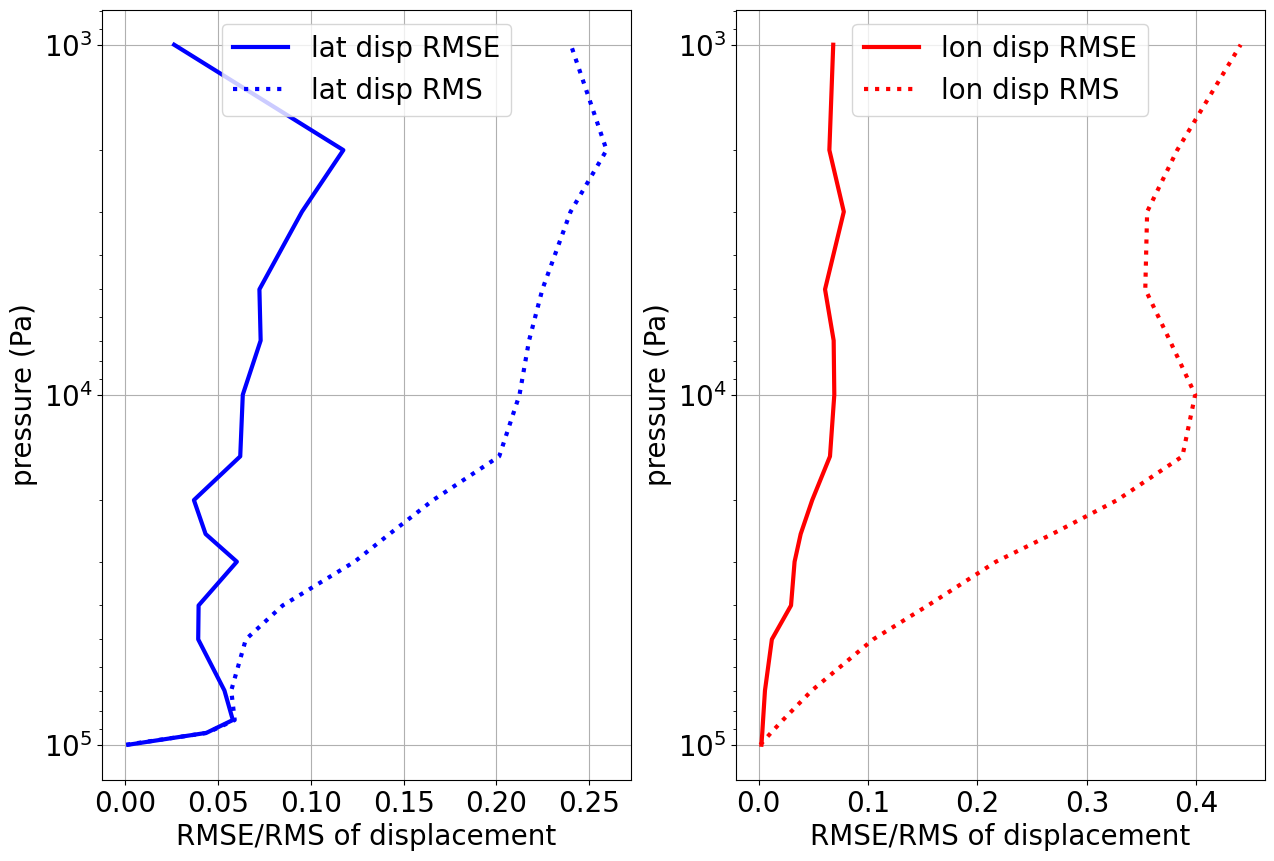

<function numpy.nanmax(a, axis=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>

In [ ]:
# ipath=os.path.expanduser('~leo/ectrans/')
# sodblist=glob.glob(ipath+'era5.bufr.202006')
# sodblist.sort(key=os.path.getsize)
# out = par_read_bufr_stn_nofeedback_mre_interp(111, sodblist[0]) #'./out.bufr')# sodblist[0])
# np.nanmax

<_io.TextIOWrapper name='/users/staff/leo/ectrans/era5.bufr.202012' mode='r' encoding='UTF-8'>
100000 -0.6860265361982387 0.4481170261141544
92500 -0.9509632961199674 0.922902431550215
85000 -0.9925907673806937 0.8927348740824772
70000 -0.8944529670843812 0.8772777825607884
50000 -0.9676973933277526 0.7453633511940908
40000 -0.8976758802600228 0.9809853890583299
30000 -0.8877850156828819 0.9490368784758088
25000 -0.8843850908580354 0.9765071328229586
20000 -0.68295432326682 0.8641189442525293
15000 -0.8850560771555025 0.9946844884163566
10000 -0.9936233256927047 0.9301340714534979
7000 -0.9287916027803881 0.6537480656743292
5000 -0.6785039195275323 0.9852490005696541
3000 -0.9891044799946337 0.8408742423224357
2000 -0.9822700357897833 0.07393032520662729
1000 -0.43186112714728764 0.4431610278490368


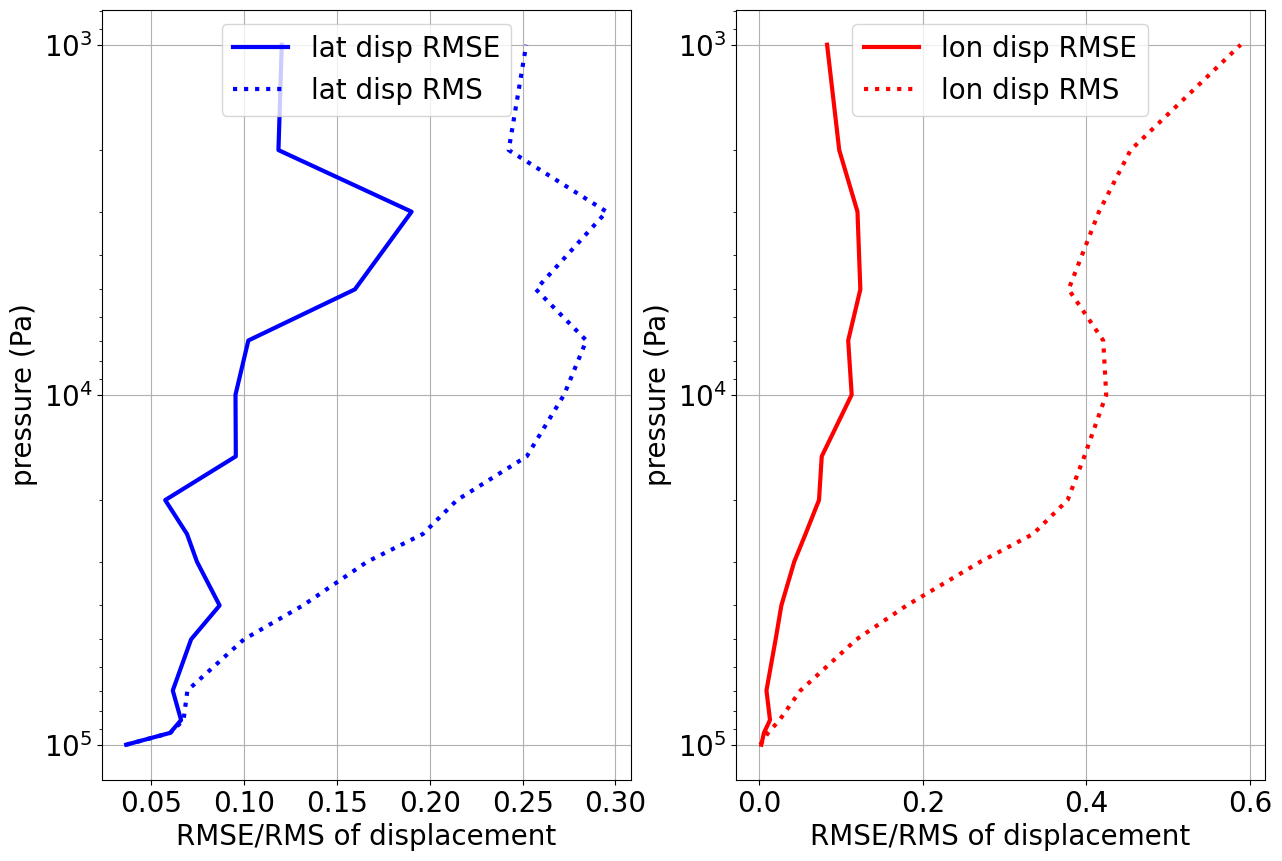

<function numpy.nanmax(a, axis=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>

In [11]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202012')
sodblist.sort(key=os.path.getsize)
out = par_read_bufr_stn_nofeedback_mre_interp(111, sodblist[0]) #'./out.bufr')# sodblist[0])
np.nanmax

<_io.TextIOWrapper name='/users/staff/leo/ectrans/era5.bufr.202009' mode='r' encoding='UTF-8'>
Please resort the input data - ascending order is necessary!
Please resort the input data - ascending order is necessary!
Please resort the input data - ascending order is necessary!
100000 -0.8027482493070105 0.01051095586614357
92500 -0.8274345892010796 0.9496421244381033
85000 -0.9958204185833123 0.9492487589423201
70000 -0.9033328100441739 0.9995140711720398
50000 -0.7905758790872591 0.8867917282215974
40000 -0.9470926845217246 0.9893318092396446
30000 -0.9083177253271223 0.7308806232094132
25000 -0.9443865491861906 0.865388829951502
20000 -0.9305106398196605 0.9807025140774108
15000 -0.8257742618698796 0.9965207325338028
10000 -0.9562706199568429 0.7391971217740914
7000 -0.24412125505869017 0.9767460411207085
5000 -0.8766619792633785 0.3101762111677695
3000 -0.9110405148113099 0.5064807922104706
2000 -0.4113417365773674 0.7485267053028558
1000 -0.2143979551468128 0.7939928471262101


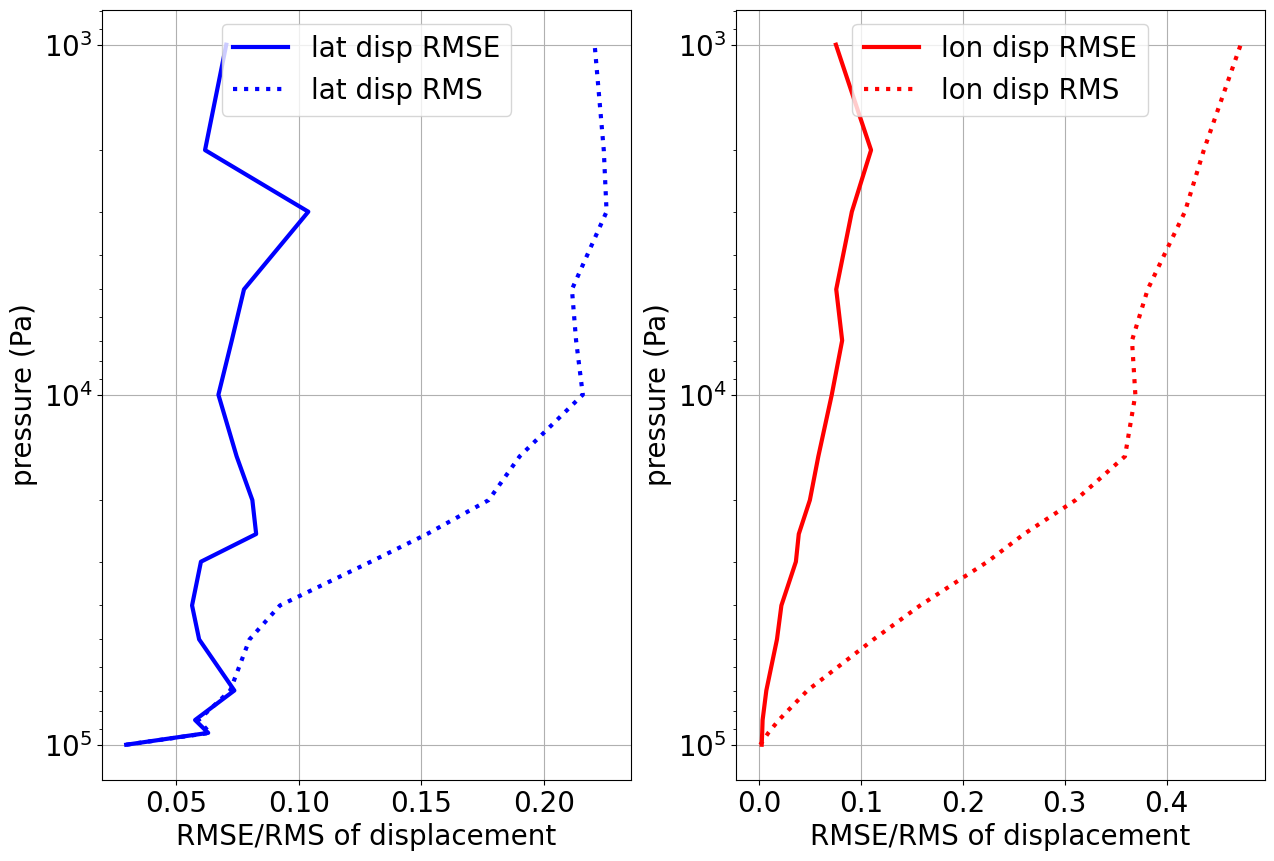

<function numpy.nanmax(a, axis=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>

In [ ]:
# ipath=os.path.expanduser('~leo/ectrans/')
# sodblist=glob.glob(ipath+'era5.bufr.202009')
# sodblist.sort(key=os.path.getsize)
# out = par_read_bufr_stn_nofeedback_mre_interp(111, sodblist[0]) #'./out.bufr')# sodblist[0])
# np.nanmax

In [ ]:
# latrms = pd.read_csv('/users/staff/uvoggenberger/digitized/fig7/lat_rms.csv',delimiter=';', names=['val', 'p'], decimal=',')
# # latrmse = pd.read_csv('/users/staff/uvoggenberger/digitized/fig7/lat_rmse.csv',delimiter=';', names=['val', 'p'], decimal=',')
# # lonrms = pd.read_csv('/users/staff/uvoggenberger/digitized/fig7/lon_rms.csv',delimiter=';', names=['val', 'p'], decimal=',')
# # lonrmse = pd.read_csv('/users/staff/uvoggenberger/digitized/fig7/lon_rmse.csv',delimiter=';', names=['val', 'p'], decimal=',')

In [63]:
latrms

,val,p
0,0.028295,92403.846154
1,0.014060,85000.000000
2,0.015290,69519.230769
3,0.021265,59134.615385
4,0.027417,49423.076923
5,0.034622,41538.461538
6,0.040949,36634.615385
7,0.050791,29903.846154
8,0.061863,24807.692308
9,0.073111,20769.230769


In [61]:
latrms = latrms.iloc[:-1]
latrms.loc[len(latrms)] = [0.117575,1000]

In [51]:
latrms = latrms.sort_values(by='p')

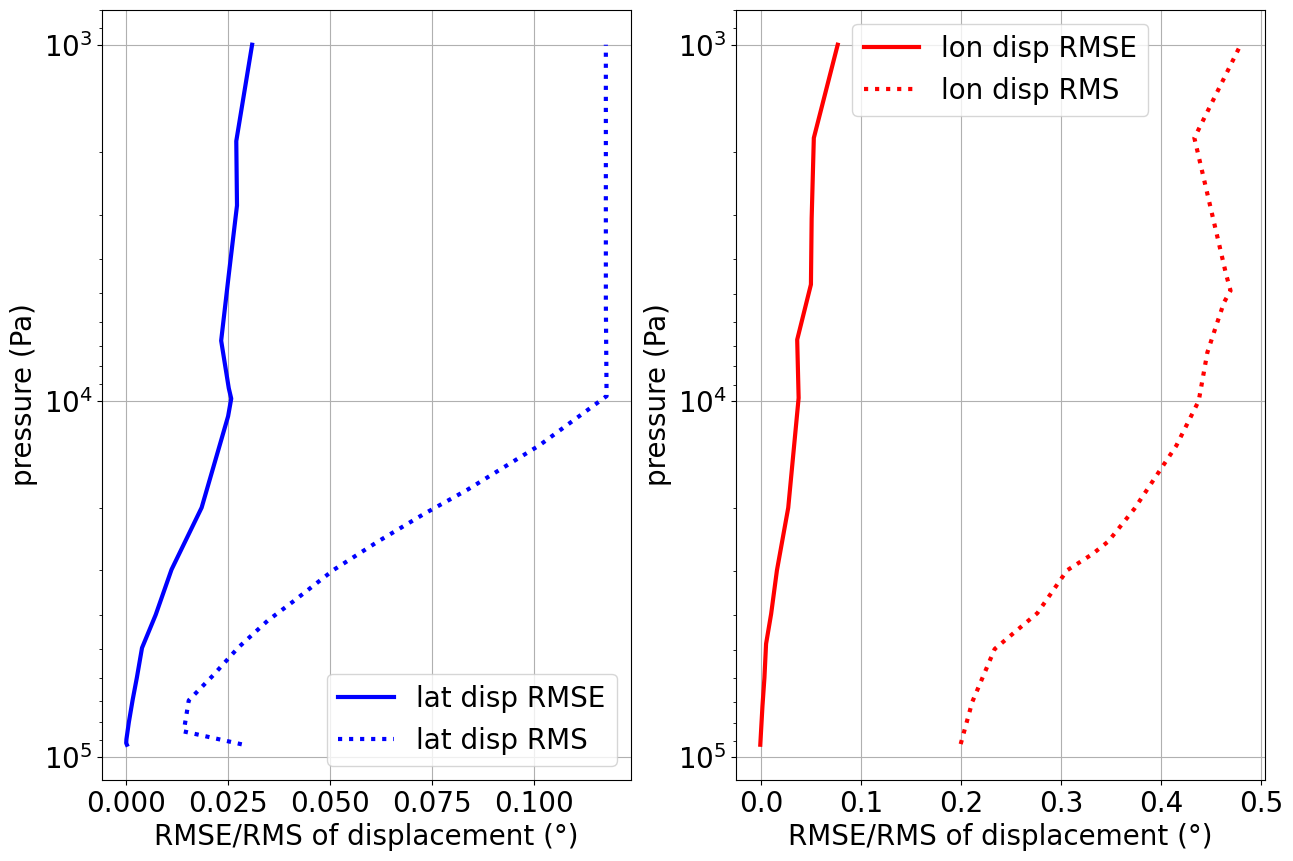

In [71]:
    fig, ax1 = maplt.subplots(1, 2, figsize = (15,10))
    ax1[0].set_yscale('log')
    ax1[0].plot(np.array(latrmse.val), latrmse.p, color = 'blue', label = 'lat disp RMSE')
    ax1[0].plot(np.array(latrms.val), latrms.p, color = 'blue', ls='dotted', label = 'lat disp RMS')
    ax1[0].set_ylim(ax1[0].get_ylim()[::-1])
    ax1[0].set_ylabel('pressure (Pa)')
    ax1[0].set_xlabel('RMSE/RMS of displacement (°)')
    ax1[0].legend(loc='lower right')
    ax1[0].grid()
    
    ax1[1].set_yscale('log')
    ax1[1].plot(np.array(lonrmse.val), lonrmse.p, color = 'red', label = 'lon disp RMSE')
    ax1[1].plot(np.array(lonrms.val), lonrms.p, color = 'red', ls = 'dotted', label = 'lon disp RMS')
    ax1[1].set_ylim(ax1[1].get_ylim()[::-1])
    ax1[1].set_ylabel('pressure (Pa)')
    ax1[1].set_xlabel('RMSE/RMS of displacement (°)')
    ax1[1].legend(loc='upper center')
    ax1[1].grid()
